# Spherical Harmonic Normalizations and Parseval's theorem

## The energy and variance of a single spherical harmonic

We demonstrate in this paragraph two properties of the 4-pi normalized spherical harmonics. Before starting, we initialize the coefficient class with a single non-zero coefficient, and to make things simple, we fix this coefficient to 1.

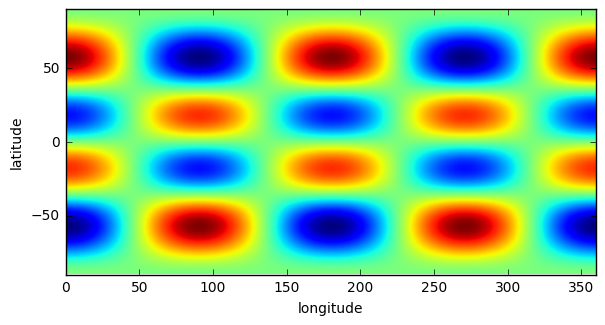

In [5]:
%matplotlib inline
from __future__ import print_function # only necessary if using Python 2.x

import matplotlib.pyplot as plt
import numpy as np
from pyshtools.shclasses import SHCoeffs, SHGrid, SHWindow

lmax = 100
coeffs = SHCoeffs.from_zeros(lmax)
coeffs.set_coeffs(values=[1], ls=[5], ms=[2])

grid = coeffs.expand('DH2')
fig, ax = grid.plot()

Next, we would like to calculate the variance of this single spherical harmonic. Since each spherical harmonic has a zero mean, this is equal to the integral of the function squared divided by the surface area of the sphere (4pi). 

$$Var(Y_{lm}(\mathbf{r})) = \frac{1}{4 \pi} \int_\Omega Y^2_{lm}(\mathbf{r})~d\Omega$$

When the spherical harmonics are 4pi normalized, by definition, the variance is 1. 

This is easily confirmed by computing the power spectrum, which is also defined as the integral of the function squared divided by 4pi. In this case, the power is zero for all degrees with the exception of `l=5`, and the sum of the power spectrum should be exactly unity:

In [6]:
power = coeffs.spectrum()
print('total power is ', power.sum())

total power is  1.0


You can also verify this by doing to integration manually, which we do in an apporoximate way:

In [7]:
# Generate an empty spatial grid
lats = grid.lats()
lons = grid.lons()
latgrid, longrid = np.meshgrid(lats, lons, indexing='ij')

# Next, compute the weights used to integrate the function.
# This will only be approximate.
weights = np.cos(np.radians(latgrid))
dlat = np.radians(lats[0] - lats[1])
dlon = np.radians(lons[1] - lons[0])
surface = weights.sum() * dlat * dlon
print('correct surface (4 pi) =', 4 * np.pi)
print('computed surface =', surface)

# Finally, compute the model variance
sh_energy = np.sum(grid.data**2 * weights) * dlat * dlon

print('computed spherical harmonics energy =', sh_energy)
print('variance = spherical harmonics energy / surface =', sh_energy / surface)

correct surface (4 pi) = 12.5663706144
computed surface = 12.5661173189
computed spherical harmonics energy = 12.5663706143
variance = spherical harmonics energy / surface = 1.00002015701


## Parseval's theorem in the case of a random model

We have seen in the previous example, that a single 4pi normalized spherical harmonic has unit variance. Because spherical harmonics are orthogonal functions on the sphere, *the total variance of a model is the sum of the variances of its' 4pi-normalized spherical harmonics coefficients*.

If the coefficients of all spherical harmonics are independent, the distribution will become Gaussian as predicted by the central limit theorem, or it will be perfectly Gaussian if the individual coefficients were Gaussian in the first place.

We illustrate this behaviour in the following short code snippet.

total coefficient power = 42.5618932991


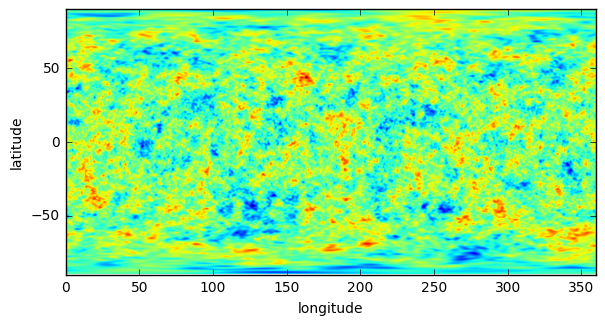

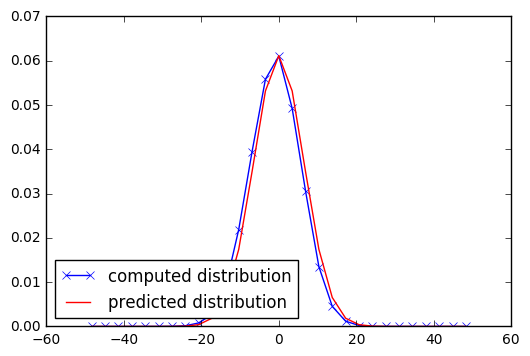

In [8]:
nl = 200
a = 30
ls = np.arange(nl, dtype=float)
power = 1. / (1. + (ls / a) ** 2) ** 1
coeffs = SHCoeffs.from_random(power)
power_random = coeffs.spectrum()
total_power = power_random.sum()
print('total coefficient power =', total_power)

grid = coeffs.expand('DH2')
grid.plot()

# Generate a spatial grid.
lats = grid.lats()
lons = grid.lons()
latgrid, longrid = np.meshgrid(lats, lons, indexing='ij')

# First, compute the spherical surface element to weight
# the different grid points when constructing a histogram.
weights = np.cos(np.radians(latgrid))
dlat = np.radians(lats[0] - lats[1])
dlon = np.radians(lons[1] - lons[0])
surface = weights.sum() * dlat * dlon

# Compute a histogram of the grided data.
bins = np.linspace(-50, 50, 30)
center = 0.5 * (bins[:-1] + bins[1:])
dbin = center[1] - center[0]
hist, bins = np.histogram(grid.data, bins=bins, weights=weights, density=True)

# Compute the expected distribution.
normal_distribution = np.exp( - center ** 2 / (2 * total_power))
normal_distribution /= dbin * normal_distribution.sum()

# Plot both distributions.
fig, ax = plt.subplots(1, 1)
ax.plot(center, hist, '-x', c='blue', label='computed distribution')
ax.plot(center, normal_distribution, c='red', label='predicted distribution')
ax.legend(loc=3);